In [2]:
from myclasses.sql_executor import SQLExecutor

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT * FROM aggCostReports
        """

    # Execute the query and get the result as a DataFrame
    costreport_df = sql_executor.execute_query(query)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Dict to map ownership number to a prescribed category 
ownership_dict = {
    1: 'non-profit church',
    2: 'non-profit other',
    3: 'proprietary individual',
    4: 'proprietary corporation',
    5: 'proprietary partnership',
    6: 'proprietary other',
    7: 'government federal',
    8: 'government city-county',
    9: 'government county',
    10: 'government state',
    11: 'government district',
    12: 'government city',
    13: 'government other'
}

# Map ownership type to the DataFrame
costreport_df['ownership_type'] = costreport_df['ownership'].map(ownership_dict)
costreport_df_clean = costreport_df.dropna(subset=['net_income'])

time_series_dict = {}

# Loop to create a unique group for each years total income type with it's associated ownership type
for i, g in costreport_df_clean[['ownership_type','fiscal_year','net_income']].groupby(['ownership_type','fiscal_year']):
    time_series_dict[i] = list(g['net_income'])

In [4]:
# Function to remove outliers using IQR method
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x/1000 for x in data if lower_bound <= x <= upper_bound]

# Function to create a box and whisker plot for the ownership type
def box_and_whisker(ownership):
    filtered_dict = {key[1]: value for key, value in time_series_dict.items() if key[0] == ownership}
    sorted_dict = dict(sorted(filtered_dict.items()))

    # Remove outliers from the data
    cleaned_dict = {year: remove_outliers(values) for year, values in sorted_dict.items()}

    data = list(cleaned_dict.values())
    labels = list(cleaned_dict.keys())

    # Get the length of each years observations
    n = [len(sublist) for sublist in data]

    # Concatenate lengths with labels
    labels_with_n = [f'{label}\n(n={count})' for label, count in zip(labels, n)]

    fig, ax = plt.subplots(figsize= (10,6))

    ax.boxplot(data, patch_artist=True)
    ax.set_xticklabels(labels_with_n)
    ax.set_ylabel('Net Income (thousands)')

    plt.suptitle(f'Net Income Box and Whiskers: {ownership}')
    plt.grid(True)

    # Adjust the layout to expand x-axis
    plt.tight_layout() 

    plt.show()

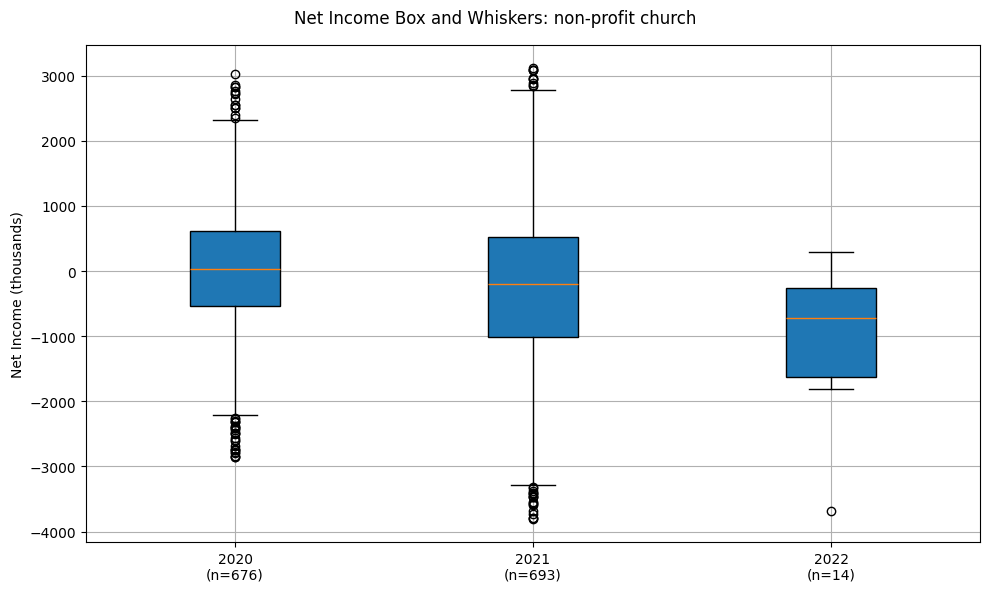

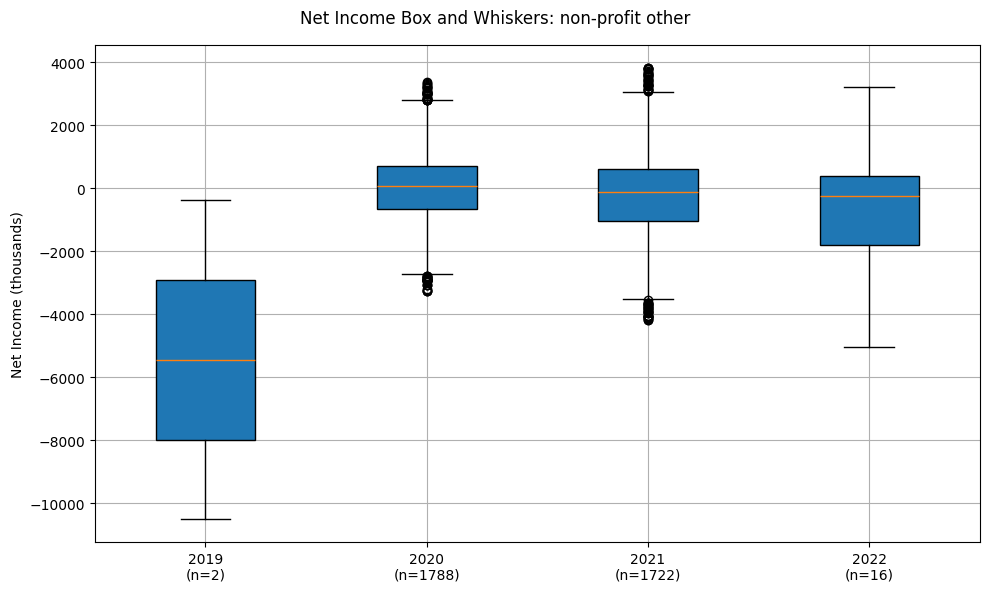

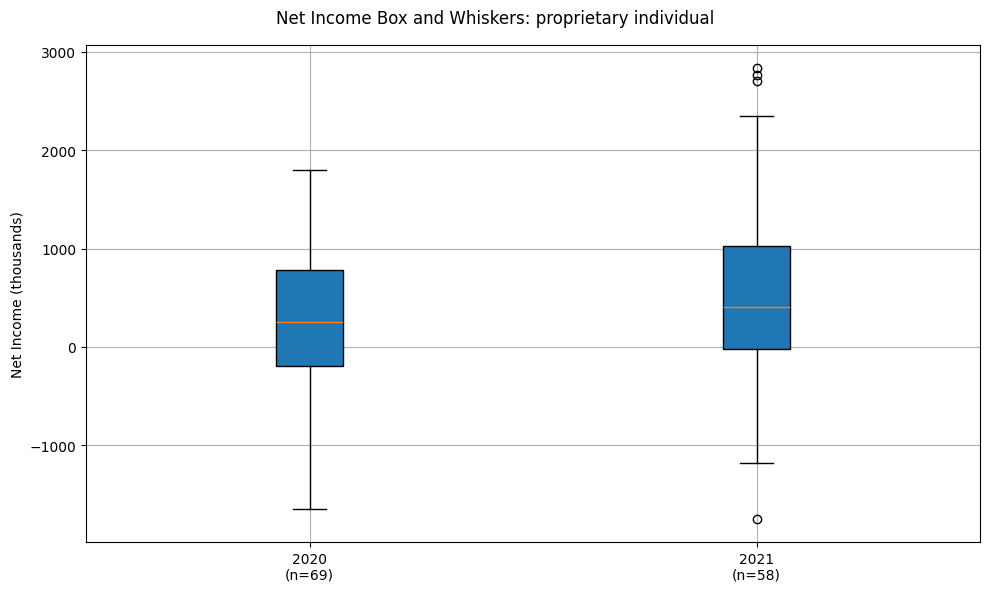

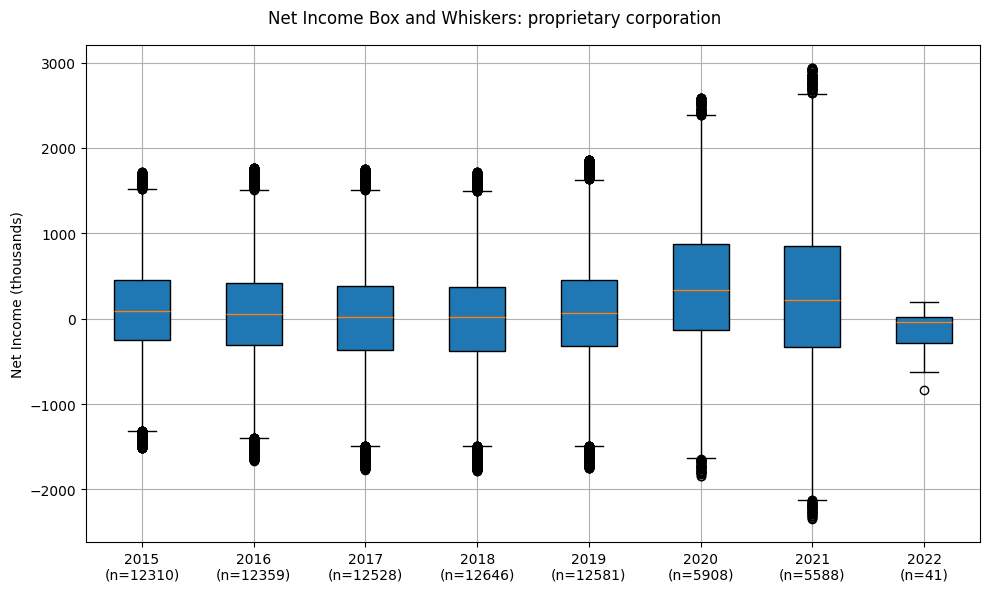

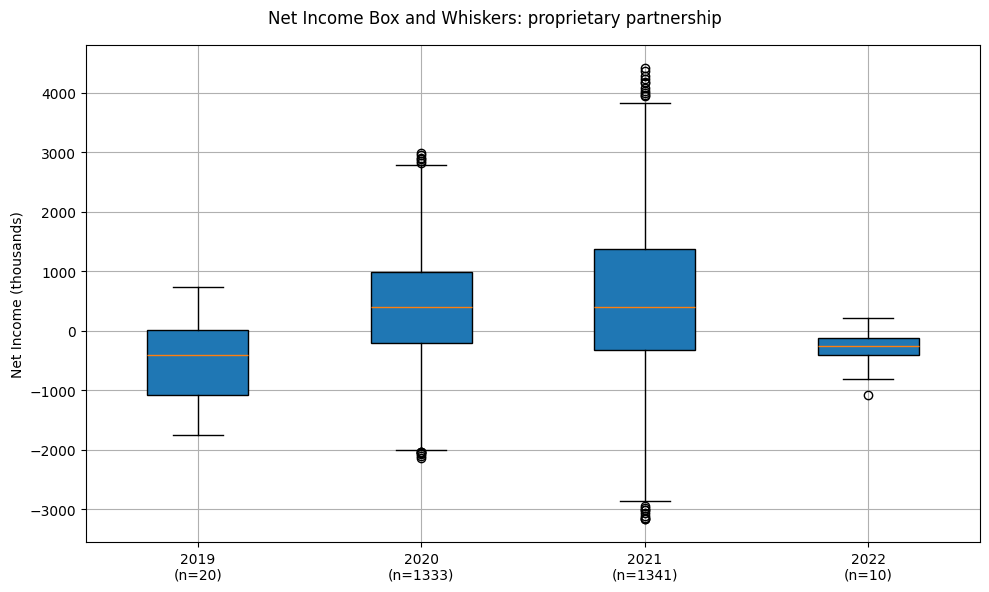

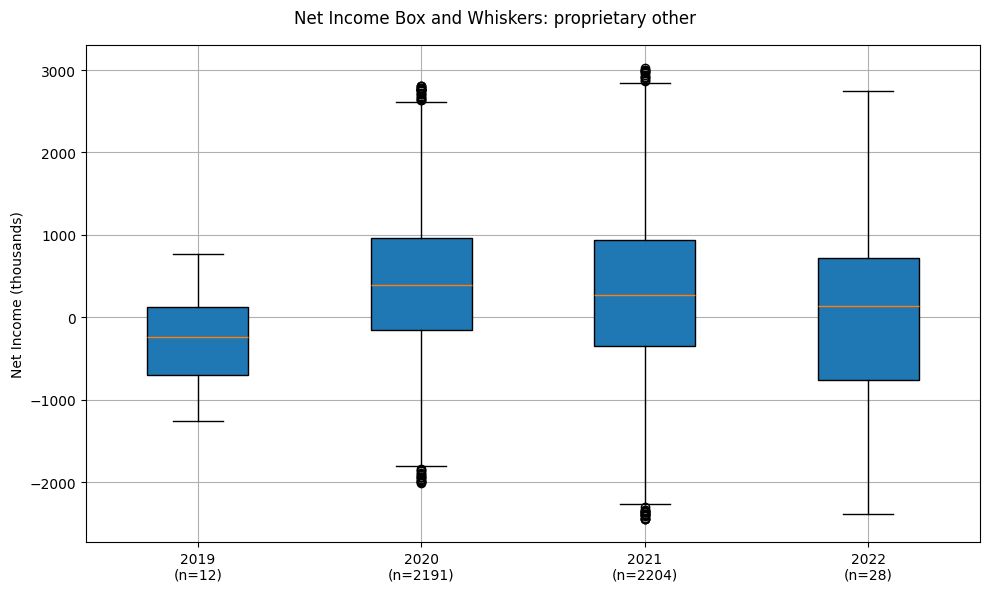

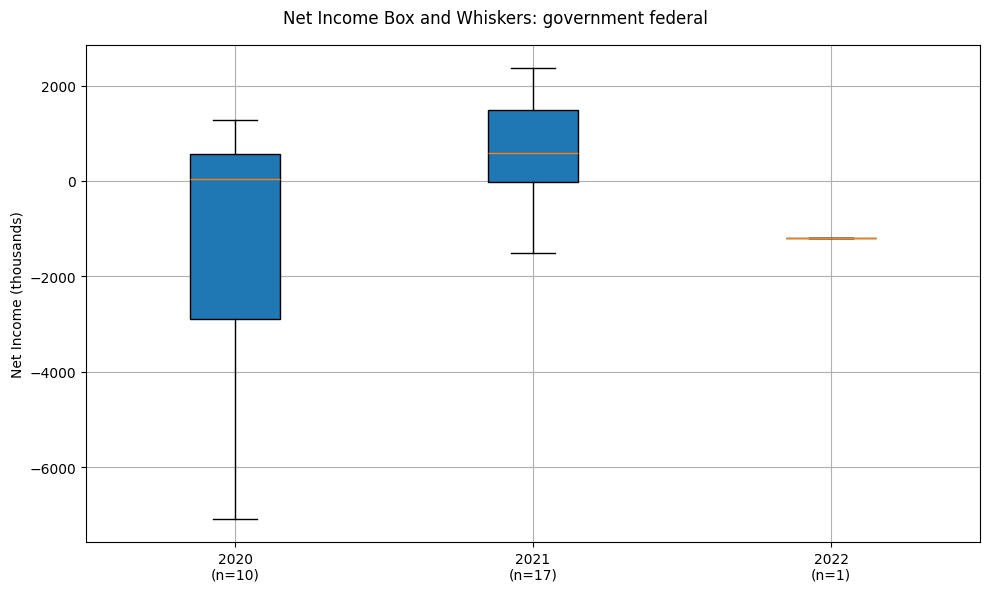

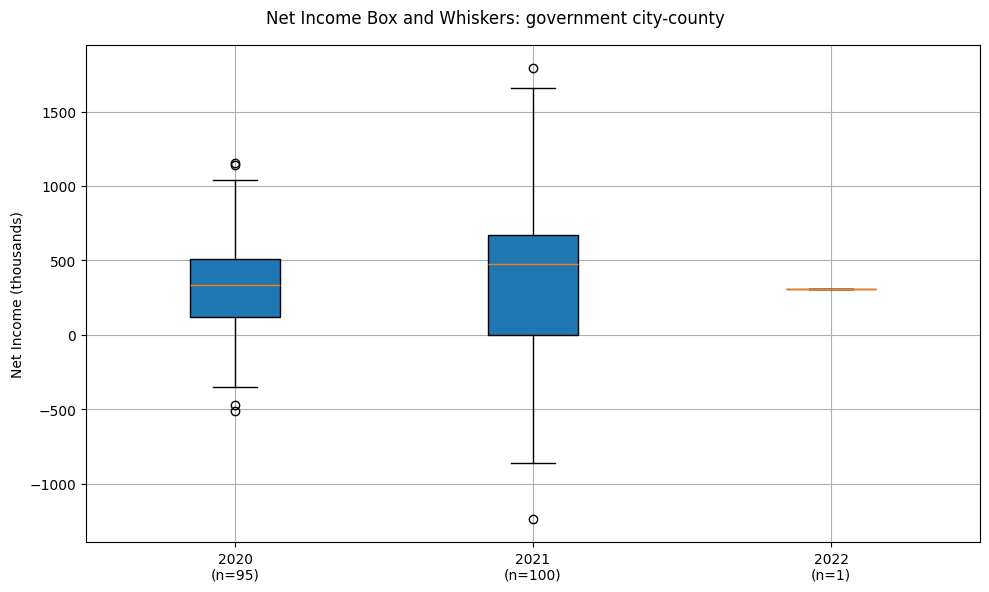

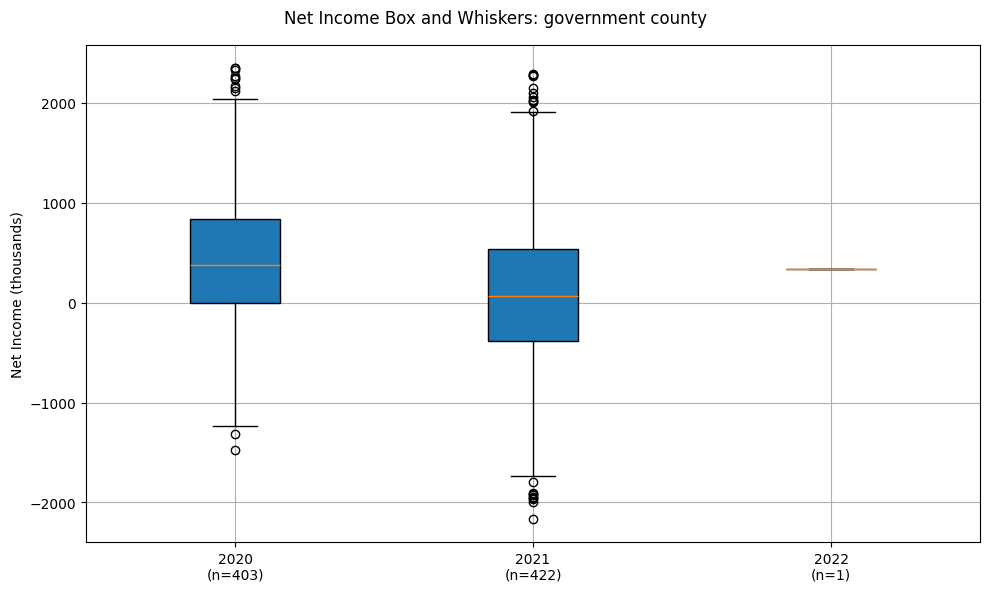

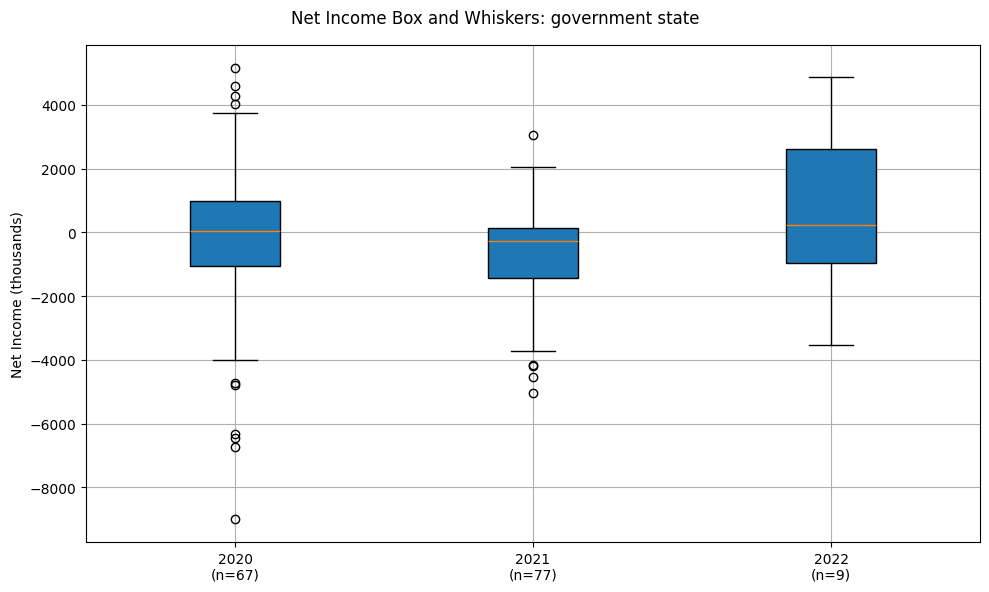

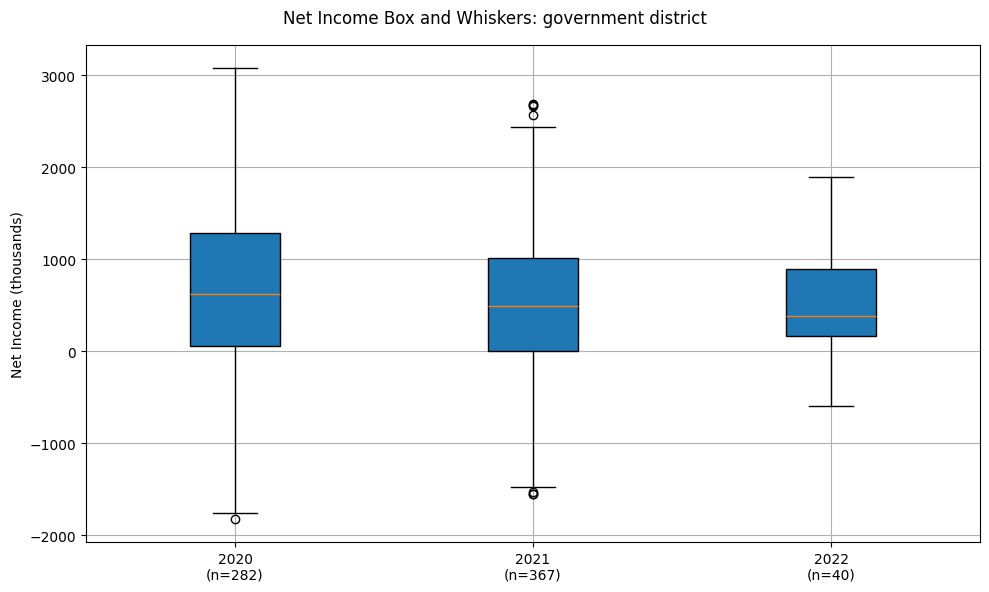

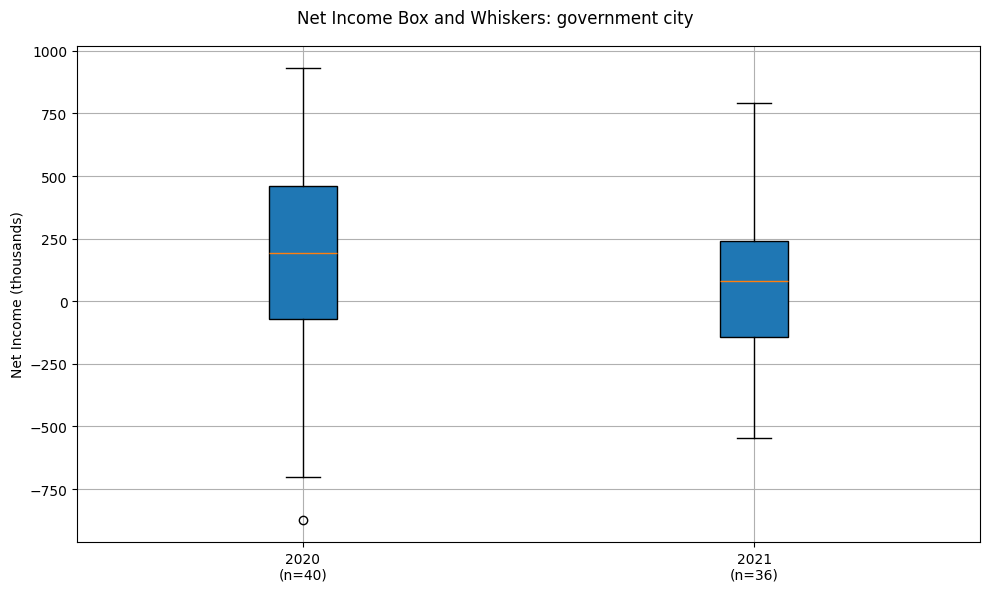

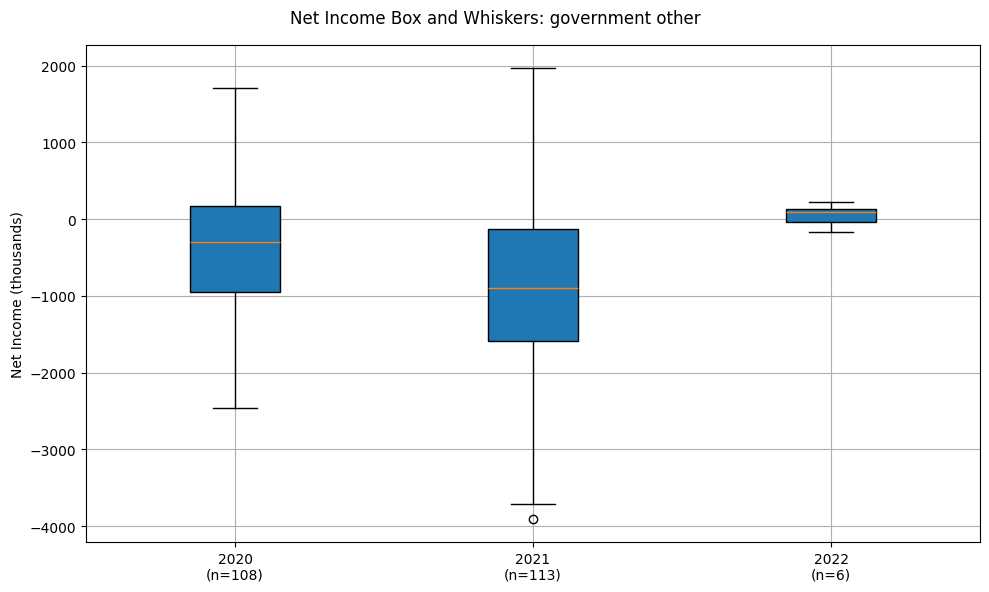

In [5]:
for v in ownership_dict.values():
    box_and_whisker(v)

In [6]:
if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT * FROM HealthDeficiencies;
        """

    # Execute the query and get the result as a DataFrame
    health_df = sql_executor.execute_query(query)

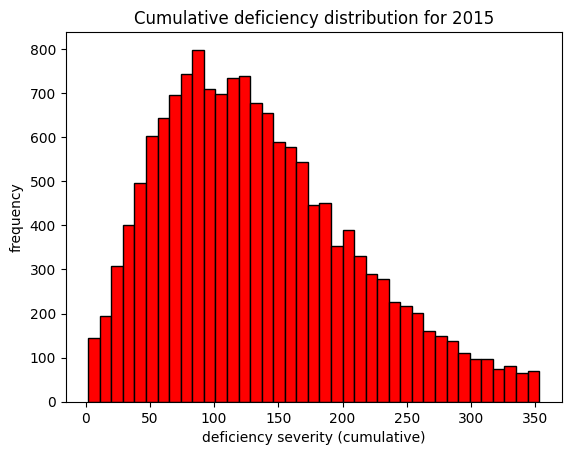

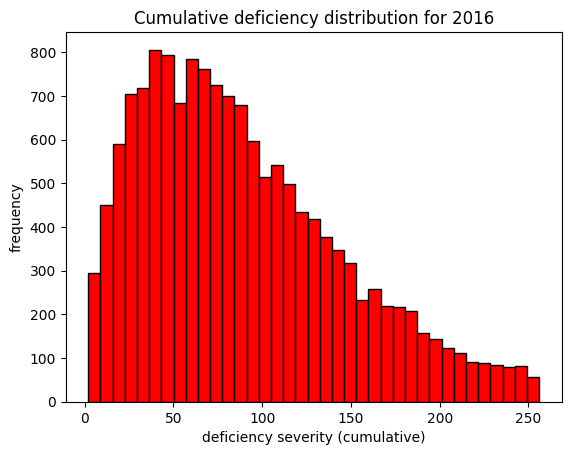

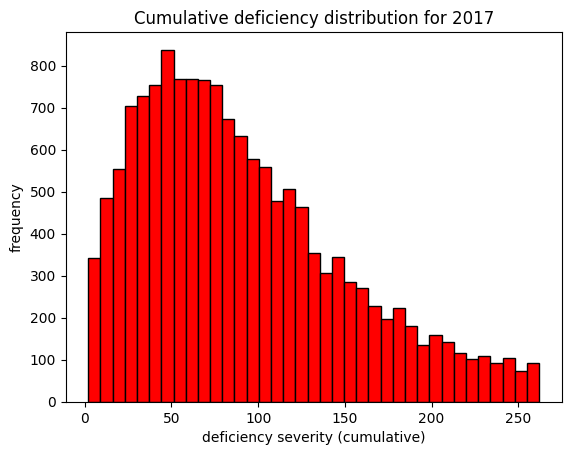

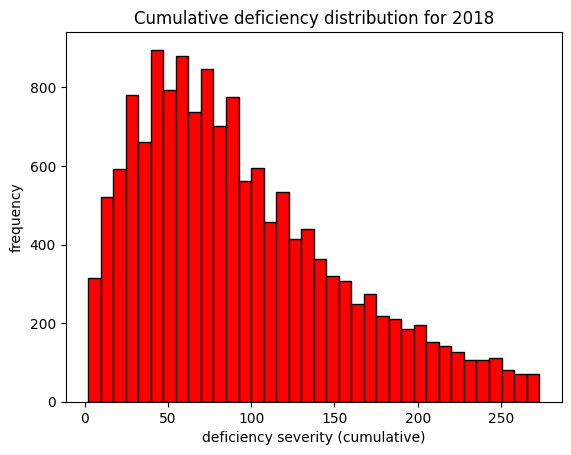

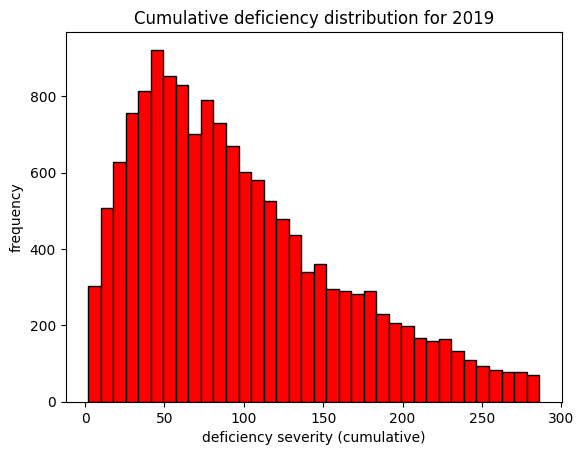

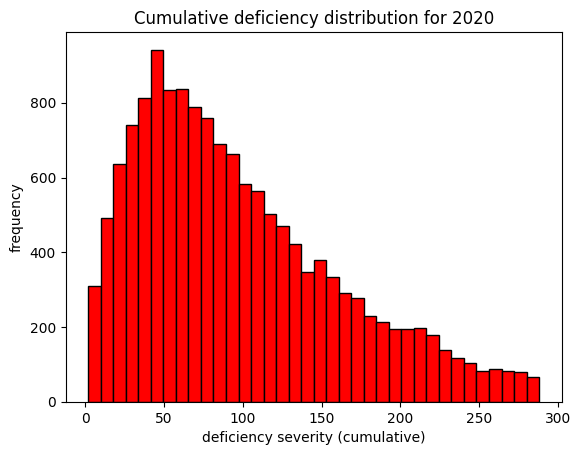

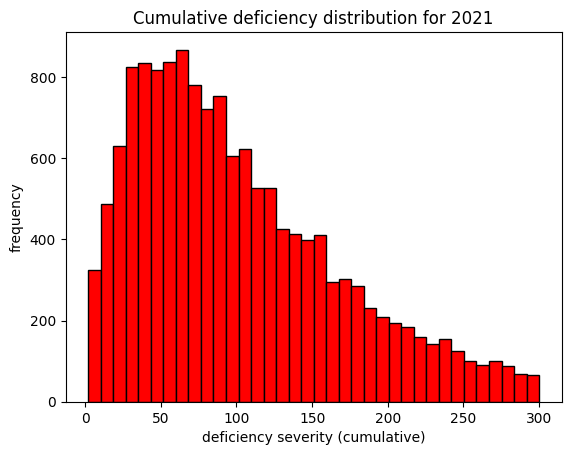

In [7]:
# Change the scope variable to numerical. Reduce the ascii by 96 so that scope of a = 1 and so on
health_df['num_scope'] = health_df['scope'].apply(lambda x: ord(x) - 96).tolist()

# Set the report year
health_df['report_year'] = health_df['filedate'].str[:4].astype(int)

# Group the health df by prov_id and report year
grouped_health_df = health_df.groupby(['prov_id', 'report_year'])['num_scope'].sum().reset_index()
unique_years = grouped_health_df['report_year'].unique()

def_pct_dict = {}

# Plot the each years grouped scope data into a histogram to see the distribution of health deficiencies across all nursing homes
for year in unique_years:

   # Filter the DataFrame for the current year
   data = grouped_health_df[grouped_health_df['report_year'] == year]['num_scope']

   # Calculate the first and third quartiles
   q1, mean, q3 = np.percentile(data, [25, 50, 75])
   iqr = q3 - q1   

   def_pct_dict[year] = [q1, mean, q3]

   # Set the lower and upper bounds for outlier removal
   lower_bound = q1 - 1.5 * iqr
   upper_bound = q3 + 1.5 * iqr

   # Remove outliers for visualization
   data = data[(data >= lower_bound) & (data <= upper_bound)]

   # Calculate bin width using Freedman-Diaconis' rule
   bin_width = 2 * iqr / len(data) ** (1/3)

   # Calculate number of bins based on bin width
   num_bins = int((max(data) - min(data)) / bin_width)

    # Plotting the histogram
   plt.hist(data, bins= num_bins, color= 'red', edgecolor= 'black')

   plt.xlabel('deficiency severity (cumulative)')
   plt.ylabel('frequency')
   plt.title(f'Cumulative deficiency distribution for {year}')

   plt.show()

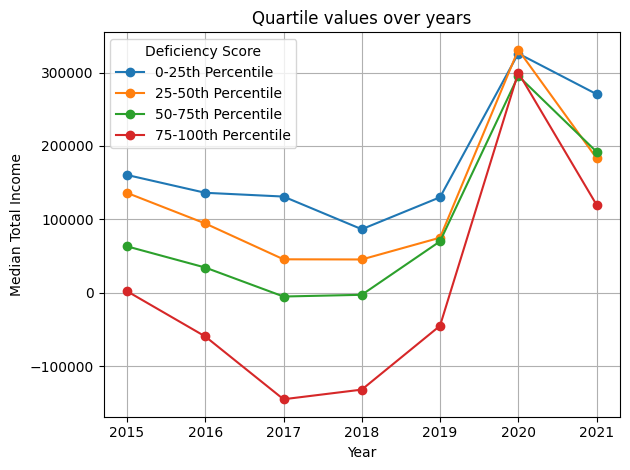

In [12]:
def_income_df = grouped_health_df[['prov_id', 'num_scope', 'report_year']].merge(
    costreport_df_clean[['prov_id', 'fiscal_year', 'net_income']],
    how='inner',
    left_on=['prov_id', 'report_year'],
    right_on=['prov_id', 'fiscal_year']
).drop(['fiscal_year'], axis=1)

# Function to assign the quartile
def assign_quartile(x, year):
    # Pull the years quartile benchmarks
    quartile_benchmarks = def_pct_dict[year]
    if x < quartile_benchmarks[0]:
        return "0-25th Percentile"
    elif x < quartile_benchmarks[1]:
        return "25-50th Percentile"
    elif x < quartile_benchmarks[2]:
        return "50-75th Percentile"
    else:
        return "75-100th Percentile"

quartiles = []

# Loop through the DataFrame and assign the quartile of num_scope for each year
for index, row in def_income_df.iterrows():
    
    # Pull the scope and report year
    num_scope, report_year = row[['num_scope','report_year']]
    report_year = int(report_year)

    # Run the num_scope through the function to map it's quartile
    quartile = assign_quartile(num_scope, report_year)
    quartiles.append(quartile)

def_income_df['quartile'] = quartiles

deficiency_income_quartiles = def_income_df.drop(['num_scope','prov_id'],axis= 1).groupby(['report_year','quartile']).median().reset_index()

# Pivot the data
pivot_df = deficiency_income_quartiles.pivot(index='report_year', columns='quartile', values='net_income')

# Plot
pivot_df.plot(marker='o')
plt.title('Quartile values over years')
plt.xlabel('Year')
plt.ylabel('Median Total Income')
plt.grid(True)
plt.legend(title='Deficiency Score')
plt.tight_layout()
plt.show()

In [18]:
import mysql.connector
from sqlalchemy import create_engine

# MySQL connection parameters
host= 'localhost'
user= 'josh'
password= 'go$T4GS'
database= 'data_4999'

# Create MySQL connection
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")

# Upload the yearly deficiency score to SQL
grouped_health_df[['prov_id','num_scope','report_year']].to_sql('DeficiencyYear', con=engine, if_exists='replace', index=False)

# Close the connection
engine.dispose()